In [1]:
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API


print("Environment Ready")

Environment Ready


In [2]:
# Setup:
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
cfg.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
profile = pipe.start(cfg)

# # Skip 5 first frames to give the Auto-Exposure time to adjust
# for x in range(5):
#     pipe.wait_for_frames()

# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# Cleanup:
pipe.stop()
print("Frames Captured")

Frames Captured


In [3]:
# rs = RealsenseCamera()

# while True:
#     #Get frame in realtime from realsense camera
#     ret, bgr_frame, depth_frame = rs.get_frame_stream()
    
#     cv2.imshow("Depth frame", depth_frame)
#     cv2.imshow("BGR frame", bgr_frame)
    
#     key = cv2.waitKey(1)
#     if key == 27:
#         break

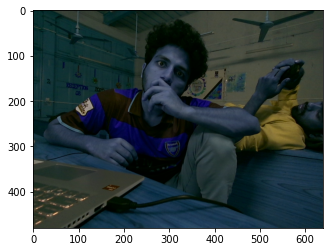

In [4]:
color = np.asanyarray(color_frame.get_data())
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.imshow(color)

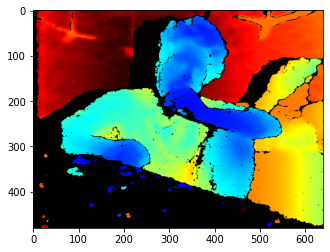

In [5]:
colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
plt.imshow(colorized_depth)

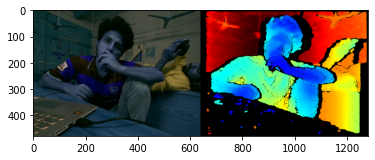

In [6]:
# Create alignment primitive with color as its target stream:
align = rs.align(rs.stream.color)
frameset = align.process(frameset)

# Update color and depth frames:
aligned_depth_frame = frameset.get_depth_frame()
colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

# Show the two frames together:
images = np.hstack((color, colorized_depth))
plt.imshow(images)

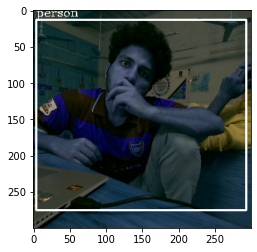

In [7]:
# Standard OpenCV boilerplate for running the net:
height, width = color.shape[:2]
expected = 300
aspect = width / height
resized_image = cv2.resize(color, (round(expected * aspect), expected))
crop_start = round(expected * (aspect - 1) / 2)
crop_img = resized_image[0:expected, crop_start:crop_start+expected]

prototxt_path = r"C:\Users\User\Desktop\Test Jupyter\MobileNetSSD_deploy.prototxt.txt"
model_path = r"C:\Users\User\Desktop\Test Jupyter\MobileNetSSD_deploy.caffemodel"
net = cv2.dnn.readNetFromCaffe(prototxt_path, model_path)

inScaleFactor = 0.007843
meanVal       = 127.53
classNames = ("background", "aeroplane", "bicycle", "bird", "boat",
              "bottle", "bus", "car", "cat", "chair",
              "cow", "diningtable", "dog", "horse",
              "motorbike", "person", "pottedplant",
              "sheep", "sofa", "train", "tvmonitor")

blob = cv2.dnn.blobFromImage(crop_img, inScaleFactor, (expected, expected), meanVal, False)
net.setInput(blob, "data")
detections = net.forward("detection_out")

label = detections[0,0,0,1]
conf  = detections[0,0,0,2]
xmin  = detections[0,0,0,3]
ymin  = detections[0,0,0,4]
xmax  = detections[0,0,0,5]
ymax  = detections[0,0,0,6]

className = classNames[int(label)]
cv2.rectangle(crop_img, (int(xmin * expected), int(ymin * expected)), 
             (int(xmax * expected), int(ymax * expected)), (255, 255, 255), 2)
cv2.putText(crop_img, className, 
            (int(xmin * expected), int(ymin * expected) - 5),
            cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,255,255))

plt.imshow(crop_img)


In [8]:
# # Standard OpenCV boilerplate for running the net:
# height, width = color.shape[:2]
# expected = 350
# aspect = width / height
# resized_image = cv2.resize(color, (round(expected * aspect), expected))
# crop_start = round(expected * (aspect - 1) / 2)
# crop_img = resized_image[0:expected, crop_start:crop_start+expected]

# xmin = 0
# xmax = 640
# ymin = 0
# ymax = 480
# scale = height / expected
# xmin_depth = int((xmin * expected + crop_start) * scale)
# ymin_depth = int((ymin * expected) * scale)
# xmax_depth = int((xmax * expected + crop_start) * scale)
# ymax_depth = int((ymax * expected) * scale)
# xmin_depth,ymin_depth,xmax_depth,ymax_depth
# cv2.rectangle(colorized_depth, (xmin_depth, ymin_depth), 
#              (xmax_depth, ymax_depth), (255, 255, 255), 2)
# plt.imshow(colorized_depth)

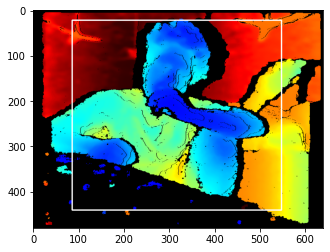

In [9]:
scale = height / expected
xmin_depth = int((xmin * expected + crop_start) * scale)
ymin_depth = int((ymin * expected) * scale)
xmax_depth = int((xmax * expected + crop_start) * scale)
ymax_depth = int((ymax * expected) * scale)
xmin_depth,ymin_depth,xmax_depth,ymax_depth
cv2.rectangle(colorized_depth, (xmin_depth, ymin_depth), 
             (xmax_depth, ymax_depth), (255, 255, 255), 2)
plt.imshow(colorized_depth)

In [10]:
depth = np.asanyarray(aligned_depth_frame.get_data())
# Crop depth data:
depth = depth[xmin_depth:xmax_depth,ymin_depth:ymax_depth].astype(float)

# Get data scale from the device and convert to meters
depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
depth = depth * depth_scale
dist,_,_,_ = cv2.mean(depth)
print("Detected a {0} {1:.3} meters away.".format(className, dist))
print(depth)
print(dist)

Detected a person 1.29 meters away.
[[5.85200028 5.79500028 5.76700027 ... 5.71100027 5.71100027 5.71100027]
 [5.88100028 5.82300028 5.76700027 ... 5.68400027 5.68400027 5.68400027]
 [5.91000028 5.85200028 5.79500028 ... 5.65700027 5.65700027 5.65700027]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
1.2871423813458258


In [11]:
# depth_max = np.max(depth)
# depth_min = np.min(depth)
# depth_diff = depth_max - depth_min
# tidal_volume = contour_area * depth_diff